In [1]:
using CSV
using DataFrames
using Flux
using HypothesisTests
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

using BSON: @save
using BSON: @load

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 1 method)

In [2]:
train_new_model = true

true

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [4]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

This time I scale data down to fall between 0 and 1

In [5]:
function transform2(scaler, data)
    [(d - scaler.data_min)/(scaler.data_max - scaler.data_min) for d in data]
end

function inverse_transform2(scaler, data_scaled)
    [(scaler.data_max - scaler.data_min)*(d_s) + scaler.data_min for d_s in data_scaled]
end

function fit_transform2(data)
    scaler = MinMaxScaler(0., 0.)
    fit!(scaler, data)
    transform2(scaler, data)
end

function minmaxscaledf2(df)
    scaled_data_dict = Dict(colname=>[] for colname in names(df))
    scalers = Dict(colname=>MinMaxScaler(0., 0.) for colname in names(df))

    for colname in names(df)
        data = df[!, colname]
        scaler = MinMaxScaler(0., 0.)
        fit!(scaler, data)

        scaled_data_dict[colname] = transform2(scaler, data)
        scalers[colname] = scaler
    end
    return DataFrame(scaled_data_dict), scalers
end

minmaxscaledf2 (generic function with 1 method)

In [6]:
x_df = decorrelatedvars(x_df);
x_df, _ = minmaxscaledf2(x_df);
y_df, y_scalers = minmaxscaledf2(y_df);

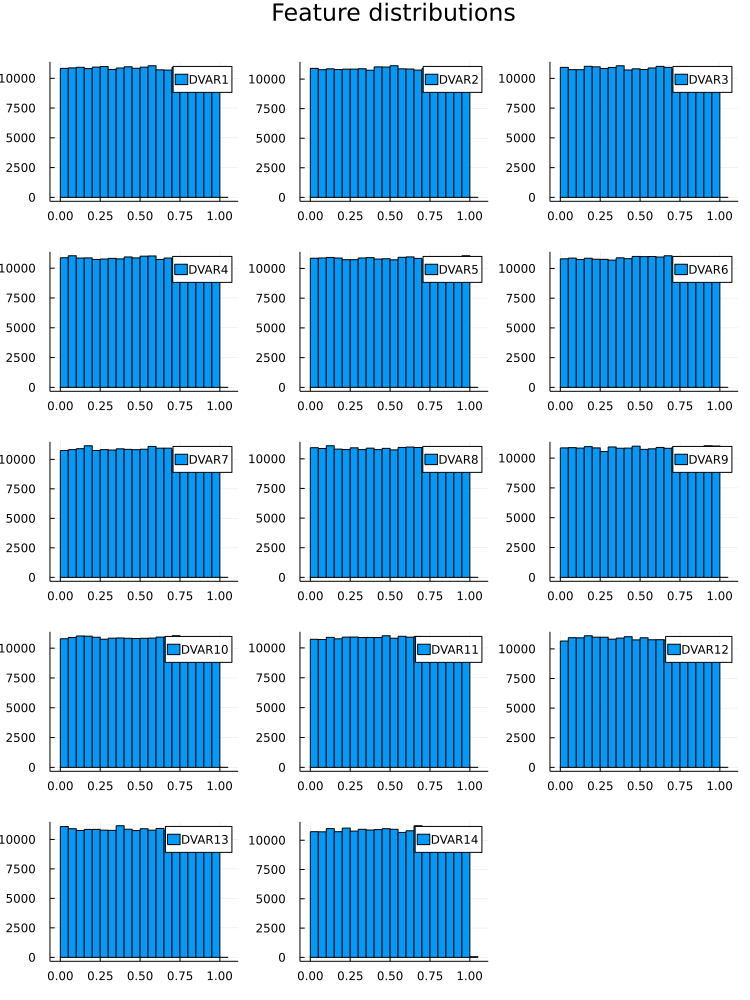

In [7]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

In [8]:
x_train_df, x_test_df, y_train_df, y_test_df = traintestsplit(x_df, y_df; read_in=true, path="../indexes/")

x_train = Float64.(Matrix(x_train_df));
x_test = Float64.(Matrix(x_test_df));
y_train = Float64.(Matrix(y_train_df));
y_test = Float64.(Matrix(y_test_df));

- Using preexisting train and test sets


In [9]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [10]:
# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 100, x->relu.(x)),
        (Dense(100, 100, x->relu.(x)) for _ in 1:5)...,
        Dense(100, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [11]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [12]:
# training, otherwise loading
if train_new_model
    m = neuralnetwork()
    optimizer = ADAM()
    loss(x, y) = Flux.mse(m(x), y)

    # training
    n_epochs = 2500
    training_losses = Float32[]
    epochs = Int32[]
    training_times = Float32[]

    for epoch in 1:n_epochs
        print("epoch $epoch,")
        start_time = time()
        Flux.train!(loss, Flux.params(m), data_loader, optimizer)
        end_time = time()
        push!(epochs, epoch)
        l = 0.
        for d in data_loader
            l += loss(d...)
        end
        println(" loss=$l")
        push!(training_losses, l)
        push!(training_times, Float32(end_time - start_time))
    end
    
    # @save "trained_nn.bson" m
    # CSV.write("train_indexes.csv",  Tables.table(train_indexes), writeheader=false)
    # CSV.write("test_indexes.csv", Tables.table(test_indexes), writeheader=false)
else
    @load "trained_nn.bson" m
end

epoch 1, loss=0.5143049569954522
epoch 2, loss=0.3642329876693275
epoch 3, loss=0.3350235103709902
epoch 4, loss=0.3101709070768782
epoch 5, loss=0.29989061020447416
epoch 6, loss=0.2815249333255228
epoch 7, loss=0.2748625596624572
epoch 8, loss=0.2693974766089444
epoch 9, loss=0.28125112861608265
epoch 10, loss=0.2736029970310412
epoch 11, loss=0.2711184997233458
epoch 12, loss=0.2490259394274789
epoch 13, loss=0.2578305351627607
epoch 14, loss=0.25447699131783075
epoch 15, loss=0.24825322834181732
epoch 16, loss=0.24221951829013105
epoch 17, loss=0.24164860543299427
epoch 18, loss=0.23768349383198678
epoch 19, loss=0.2583791340158181
epoch 20, loss=0.2552668132008879
epoch 21, loss=0.24485376075796433
epoch 22, loss=0.24615420495265358
epoch 23, loss=0.230880574945437
epoch 24, loss=0.23634633020542142
epoch 25, loss=0.23381315757812
epoch 26, loss=0.2359711548851163
epoch 27, loss=0.25177410343987416
epoch 28, loss=0.22724578661044859
epoch 29, loss=0.22592671746704848
epoch 30, los

epoch 233, loss=0.21276643029938663
epoch 234, loss=0.20884663261963837
epoch 235, loss=0.19992248319671124
epoch 236, loss=0.20900849928132018
epoch 237, loss=0.2044521723748937
epoch 238, loss=0.2063464251047226
epoch 239, loss=0.20568547468567286
epoch 240, loss=0.19927119242977992
epoch 241, loss=0.207447892987483
epoch 242, loss=0.20144357289995032
epoch 243, loss=0.1984251883659604
epoch 244, loss=0.2021533085394083
epoch 245, loss=0.20063999482389597
epoch 246, loss=0.20570673163584605
epoch 247, loss=0.20071005498104058
epoch 248, loss=0.19957738150202783
epoch 249, loss=0.20416288831110788
epoch 250, loss=0.20362829882852543
epoch 251, loss=0.20253034539985976
epoch 252, loss=0.20518205976370507
epoch 253, loss=0.19912121193829138
epoch 254, loss=0.20171994660656392
epoch 255, loss=0.198549823720383
epoch 256, loss=0.2014318828467929
epoch 257, loss=0.20810224040764108
epoch 258, loss=0.20494827502083832
epoch 259, loss=0.20384410991219928
epoch 260, loss=0.20481392257805323
e

epoch 463, loss=0.1921920889408489
epoch 464, loss=0.18977857522409225
epoch 465, loss=0.19242146897203888
epoch 466, loss=0.1943224988328339
epoch 467, loss=0.1913441789394104
epoch 468, loss=0.19157314447326776
epoch 469, loss=0.19281797217627938
epoch 470, loss=0.1952552844471292
epoch 471, loss=0.19421411996153215
epoch 472, loss=0.19130056123966702
epoch 473, loss=0.1946749586578357
epoch 474, loss=0.1971134179573129
epoch 475, loss=0.19020838451090277
epoch 476, loss=0.19349900334132933
epoch 477, loss=0.200838480410978
epoch 478, loss=0.20808714772876366
epoch 479, loss=0.19186421026541134
epoch 480, loss=0.19599331621057522
epoch 481, loss=0.1914794703164799
epoch 482, loss=0.1955249617050412
epoch 483, loss=0.19790033774996732
epoch 484, loss=0.19475496187205557
epoch 485, loss=0.19236971390261562
epoch 486, loss=0.19204156175150544
epoch 487, loss=0.191430658454722
epoch 488, loss=0.1948115737935093
epoch 489, loss=0.19257853066208858
epoch 490, loss=0.19540121491462953
epoch

epoch 693, loss=0.18927564580071113
epoch 694, loss=0.18786757397556675
epoch 695, loss=0.18710829882527458
epoch 696, loss=0.18619233987214664
epoch 697, loss=0.19428009933624202
epoch 698, loss=0.186335576256834
epoch 699, loss=0.1856204983849643
epoch 700, loss=0.18464748785273638
epoch 701, loss=0.19094225248057403
epoch 702, loss=0.18725313688696704
epoch 703, loss=0.18893894182079302
epoch 704, loss=0.18568715293045526
epoch 705, loss=0.18947390031171968
epoch 706, loss=0.187749245203715
epoch 707, loss=0.1851928511120721
epoch 708, loss=0.1888314875746019
epoch 709, loss=0.184702293381451
epoch 710, loss=0.18534081095362734
epoch 711, loss=0.18545397847360504
epoch 712, loss=0.18343550382530185
epoch 713, loss=0.18782290625837642
epoch 714, loss=0.18869203291748685
epoch 715, loss=0.18574114560661836
epoch 716, loss=0.18550541275201257
epoch 717, loss=0.19306710926989562
epoch 718, loss=0.18399541416013726
epoch 719, loss=0.18499319056717342
epoch 720, loss=0.18786724521947257
e

epoch 923, loss=0.17752692583075663
epoch 924, loss=0.18183120240871806
epoch 925, loss=0.18019402721733063
epoch 926, loss=0.1858912925585778
epoch 927, loss=0.18103739993918638
epoch 928, loss=0.18364761500815965
epoch 929, loss=0.18081636299226983
epoch 930, loss=0.18564234843747882
epoch 931, loss=0.1772053112957316
epoch 932, loss=0.18279038842041714
epoch 933, loss=0.18189017180851735
epoch 934, loss=0.1795858443644424
epoch 935, loss=0.18211023340509466
epoch 936, loss=0.179250367673671
epoch 937, loss=0.1834961359614722
epoch 938, loss=0.18035171558620325
epoch 939, loss=0.18385492686781466
epoch 940, loss=0.17814748758107932
epoch 941, loss=0.17722275649224042
epoch 942, loss=0.18182345453729173
epoch 943, loss=0.17792821530184422
epoch 944, loss=0.18498023099418426
epoch 945, loss=0.18227335838142036
epoch 946, loss=0.1816922418528829
epoch 947, loss=0.178862608691559
epoch 948, loss=0.18030281595311212
epoch 949, loss=0.183092510670079
epoch 950, loss=0.17805152401887062
epo

epoch 1149, loss=0.18002920982073245
epoch 1150, loss=0.17494895628981746
epoch 1151, loss=0.1791576358906994
epoch 1152, loss=0.17498630357539102
epoch 1153, loss=0.1744653792013949
epoch 1154, loss=0.1822032250089035
epoch 1155, loss=0.1787749623303495
epoch 1156, loss=0.17716844486060995
epoch 1157, loss=0.17377506680347696
epoch 1158, loss=0.17621801738051418
epoch 1159, loss=0.1766115428808096
epoch 1160, loss=0.17759524089573192
epoch 1161, loss=0.17606381397629184
epoch 1162, loss=0.17483090201069496
epoch 1163, loss=0.17486189951318826
epoch 1164, loss=0.17873579266611755
epoch 1165, loss=0.17556765122857154
epoch 1166, loss=0.17728193071433174
epoch 1167, loss=0.18087824706528122
epoch 1168, loss=0.1757453339039873
epoch 1169, loss=0.17996795823227413
epoch 1170, loss=0.1829900356726693
epoch 1171, loss=0.1775896811049789
epoch 1172, loss=0.1776381359986313
epoch 1173, loss=0.1751302295052703
epoch 1174, loss=0.17480103253953475
epoch 1175, loss=0.17572387374072027
epoch 1176,

epoch 1372, loss=0.1729894315272722
epoch 1373, loss=0.1713733709916309
epoch 1374, loss=0.17470226967811256
epoch 1375, loss=0.1698722679568955
epoch 1376, loss=0.17291371377395962
epoch 1377, loss=0.1736118458159212
epoch 1378, loss=0.17575594558103846
epoch 1379, loss=0.17189175670089818
epoch 1380, loss=0.172961511924241
epoch 1381, loss=0.17324954138642237
epoch 1382, loss=0.17283238748942545
epoch 1383, loss=0.17855729906657375
epoch 1384, loss=0.17615308461949478
epoch 1385, loss=0.17624052807101562
epoch 1386, loss=0.17402599090470516
epoch 1387, loss=0.17116516327597472
epoch 1388, loss=0.17263409942266447
epoch 1389, loss=0.1718275717888041
epoch 1390, loss=0.17428255770656634
epoch 1391, loss=0.1719870422647678
epoch 1392, loss=0.17280109674577385
epoch 1393, loss=0.17488579992737704
epoch 1394, loss=0.17187399112315907
epoch 1395, loss=0.16986689226989235
epoch 1396, loss=0.17585365893668975
epoch 1397, loss=0.17011541074178335
epoch 1398, loss=0.173666360083559
epoch 1399,

epoch 1595, loss=0.1678946418900402
epoch 1596, loss=0.1689375019878185
epoch 1597, loss=0.171345818273904
epoch 1598, loss=0.1744317605641954
epoch 1599, loss=0.1694583613880642
epoch 1600, loss=0.17061774452200337
epoch 1601, loss=0.16962059228182494
epoch 1602, loss=0.1706583436459413
epoch 1603, loss=0.17088766926353133
epoch 1604, loss=0.168540560288769
epoch 1605, loss=0.17111808735530742
epoch 1606, loss=0.1706264015204149
epoch 1607, loss=0.17062016626402673
epoch 1608, loss=0.1690809721586632
epoch 1609, loss=0.1701328601520908
epoch 1610, loss=0.1718809466104917
epoch 1611, loss=0.1682973216046471
epoch 1612, loss=0.16919998405501693
epoch 1613, loss=0.1698827355551864
epoch 1614, loss=0.17081431887205886
epoch 1615, loss=0.16948627498155
epoch 1616, loss=0.1682880208428965
epoch 1617, loss=0.17029324526022524
epoch 1618, loss=0.1678115880357267
epoch 1619, loss=0.16809056822553672
epoch 1620, loss=0.1708508307745442
epoch 1621, loss=0.16784973664890082
epoch 1622, loss=0.169

epoch 1819, loss=0.16721893133186513
epoch 1820, loss=0.16763259105967984
epoch 1821, loss=0.16849156619897218
epoch 1822, loss=0.1649524187508541
epoch 1823, loss=0.16974273109016352
epoch 1824, loss=0.16793185729205376
epoch 1825, loss=0.16561707188906769
epoch 1826, loss=0.16672306997533304
epoch 1827, loss=0.16615404705355516
epoch 1828, loss=0.16570607380744465
epoch 1829, loss=0.16894255494645144
epoch 1830, loss=0.16376602262435583
epoch 1831, loss=0.16943629644966338
epoch 1832, loss=0.1681803350889932
epoch 1833, loss=0.1671613073070809
epoch 1834, loss=0.16862101188661993
epoch 1835, loss=0.17189252981919126
epoch 1836, loss=0.16482233496378954
epoch 1837, loss=0.1687395988585239
epoch 1838, loss=0.1682081196138697
epoch 1839, loss=0.16577587353236342
epoch 1840, loss=0.16809493101053372
epoch 1841, loss=0.1687470664723674
epoch 1842, loss=0.16771216620659637
epoch 1843, loss=0.16945935556439615
epoch 1844, loss=0.16698475923250897
epoch 1845, loss=0.16581142579210958
epoch 1

epoch 2042, loss=0.16707890295168296
epoch 2043, loss=0.16644414302423635
epoch 2044, loss=0.16854212382476091
epoch 2045, loss=0.1672641166253246
epoch 2046, loss=0.16405625924085512
epoch 2047, loss=0.16947799607504246
epoch 2048, loss=0.16612713376688093
epoch 2049, loss=0.1657444761397176
epoch 2050, loss=0.1673719240865006
epoch 2051, loss=0.16487402286374409
epoch 2052, loss=0.16439845526401015
epoch 2053, loss=0.16571743163101713
epoch 2054, loss=0.16831056847346504
epoch 2055, loss=0.1664830526517789
epoch 2056, loss=0.16906317719713848
epoch 2057, loss=0.1657905057460191
epoch 2058, loss=0.16687418842755916
epoch 2059, loss=0.16788286958583065
epoch 2060, loss=0.17319158603234258
epoch 2061, loss=0.1653767822673244
epoch 2062, loss=0.16601888425748187
epoch 2063, loss=0.16405055899973697
epoch 2064, loss=0.16572542661933504
epoch 2065, loss=0.16468924915848263
epoch 2066, loss=0.1682779174751155
epoch 2067, loss=0.16438818319573595
epoch 2068, loss=0.1647278560907072
epoch 206

epoch 2265, loss=0.16469426667841924
epoch 2266, loss=0.1634543309549668
epoch 2267, loss=0.16445610953500575
epoch 2268, loss=0.16492638652635871
epoch 2269, loss=0.16984552926153804
epoch 2270, loss=0.1644828820821918
epoch 2271, loss=0.16272859315095628
epoch 2272, loss=0.16511741216522263
epoch 2273, loss=0.1649452359482821
epoch 2274, loss=0.16748591892444895
epoch 2275, loss=0.16267289144246241
epoch 2276, loss=0.16280976458796295
epoch 2277, loss=0.16531058636616422
epoch 2278, loss=0.16224567326329087
epoch 2279, loss=0.16421376158653803
epoch 2280, loss=0.1640797823110821
epoch 2281, loss=0.16394055263014826
epoch 2282, loss=0.16494169139282008
epoch 2283, loss=0.16477157011489718
epoch 2284, loss=0.16475579398278345
epoch 2285, loss=0.16519259956493915
epoch 2286, loss=0.16116803868125432
epoch 2287, loss=0.16707850832853105
epoch 2288, loss=0.16617024585130488
epoch 2289, loss=0.1636155721486486
epoch 2290, loss=0.16664484384852718
epoch 2291, loss=0.16737660982624572
epoch 

epoch 2489, loss=0.16747727569596982
epoch 2490, loss=0.16554541523976413
epoch 2491, loss=0.16111641943897273
epoch 2492, loss=0.16444688014744188
epoch 2493, loss=0.1639602144489465
epoch 2494, loss=0.1688258337924557
epoch 2495, loss=0.1638971012528413
epoch 2496, loss=0.1644217964425087
epoch 2497, loss=0.16236205461684994
epoch 2498, loss=0.16581352213392941
epoch 2499, loss=0.16187947145443848
epoch 2500, loss=0.16677006820470036


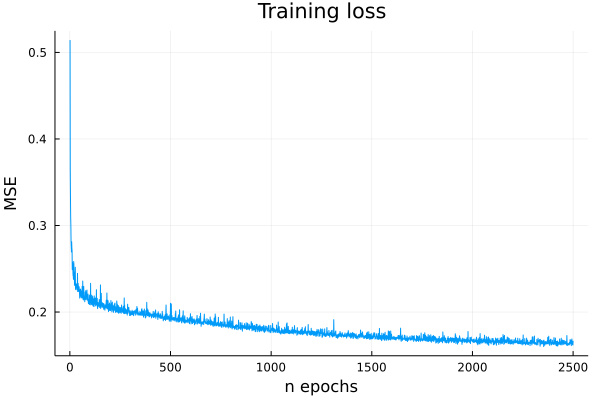

In [13]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [14]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [15]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9376060596919139
r2 on test set: 0.9066130643696075


In [16]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [17]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9376010176118291
adjustedr2 on test set: 0.9065828706766483


In [18]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.02106528417575449
mae on test set: 0.024272163227280437


In [19]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.011707415772338971
mae on test set for OBJ1: 0.012520718287685691
mae on training set for OBJ2: 0.03666600725845087
mae on test set for OBJ2: 0.037862194679862134
mae on training set for OBJ3: 0.005199872815394043
mae on test set for OBJ3: 0.005299695699846862
mae on training set for OBJ4: 0.003825602656439282
mae on test set for OBJ4: 0.003885858939611052
mae on training set for OBJ5: 0.03520269524220947
mae on test set for OBJ5: 0.0443776035753157
mae on training set for OBJ6: 0.0337901113096943
mae on test set for OBJ6: 0.0416869081813612


In [20]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

mape (generic function with 2 methods)

In [21]:
y_scalers

Dict{String, MinMaxScaler} with 6 entries:
  "OBJ4" => MinMaxScaler(0.00582, 1.34901)
  "OBJ6" => MinMaxScaler(0.00697, 0.10912)
  "OBJ2" => MinMaxScaler(0.0542, 0.087)
  "OBJ3" => MinMaxScaler(35.05, 386.37)
  "OBJ5" => MinMaxScaler(0.00731, 0.10398)
  "OBJ1" => MinMaxScaler(1.53, 99.5)

In [22]:
# mape for each response
for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = y_scalers["OBJ$i"]
    
    temp_train_preds_original = inverse_transform2(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = inverse_transform2(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = inverse_transform2(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = inverse_transform2(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for OBJ1: 0.022388637124539763
MAPE on test set for OBJ2: 0.01824411953601265
MAPE on test set for OBJ3: 0.015986240452115778
MAPE on test set for OBJ4: 0.09984430207948443
MAPE on test set for OBJ5: 0.1250427539300808
MAPE on test set for OBJ6: 0.11869849550372624


## Plotting / results

| Variable    | Name | MAPE: Me | MAPE: Paper |
| --------- | ---- | ---- | ----- |
| OBJ1  | Transmission  | 1.7% | 2.4% |
| OBJ2  | Output energy | 1.8% | 1.9% |
| OBJ3  | RFQ Length    | 1.3% | 2.0% |
| OBJ4  | Longitudinal $\epsilon$ | 4.8% | 8.2% |
| OBJ5  | $\epsilon_x$ | 11.7% | 12.8% | 
| OBJ6  | $\epsilon_y$ | 11.5% | 12.5% |

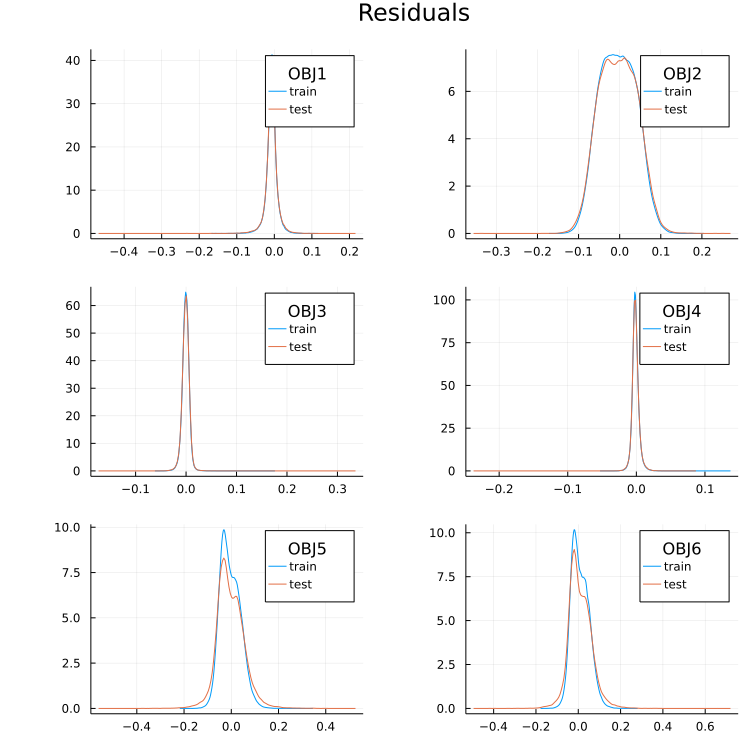

In [23]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

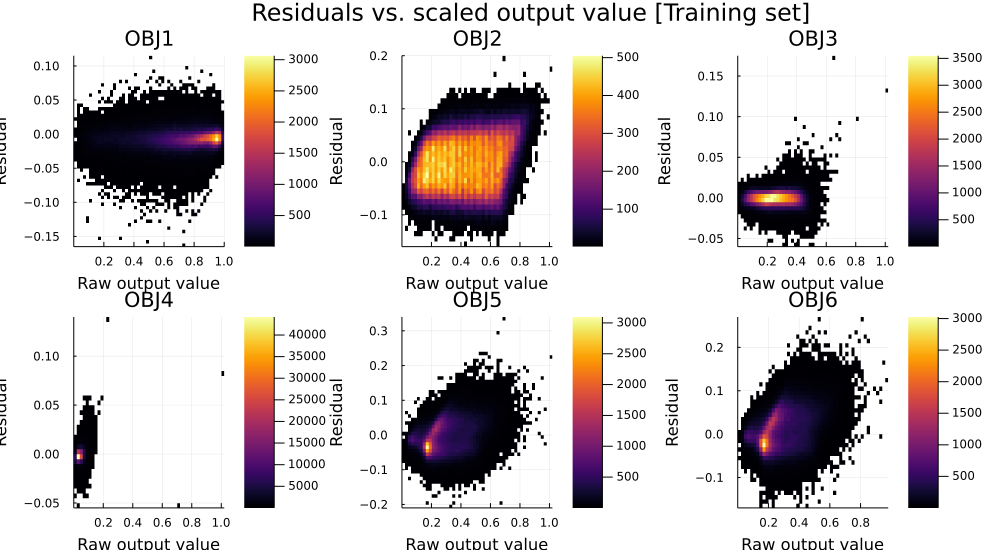

In [24]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

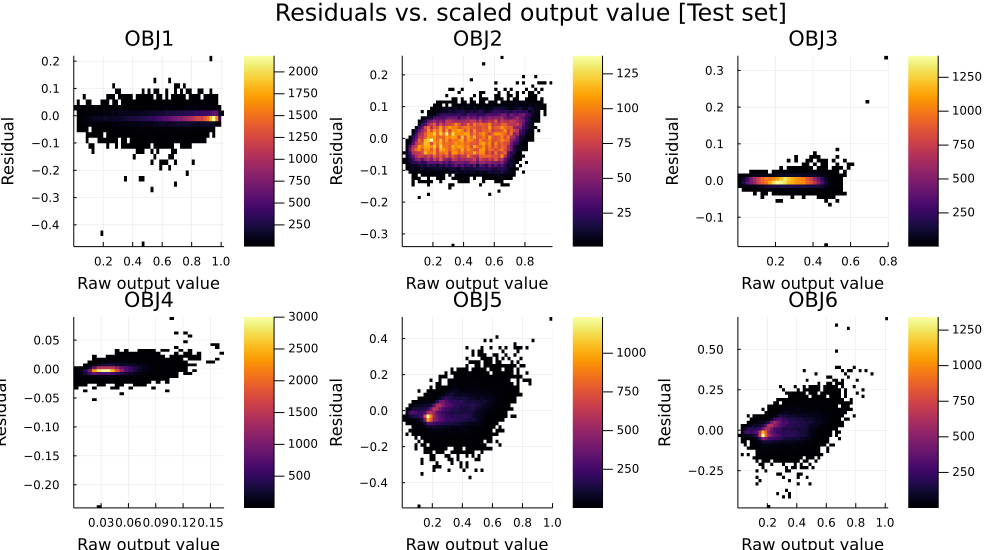

In [25]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")

How can we explain the two-band structure in the residuals of OBJ5 and OBJ6?

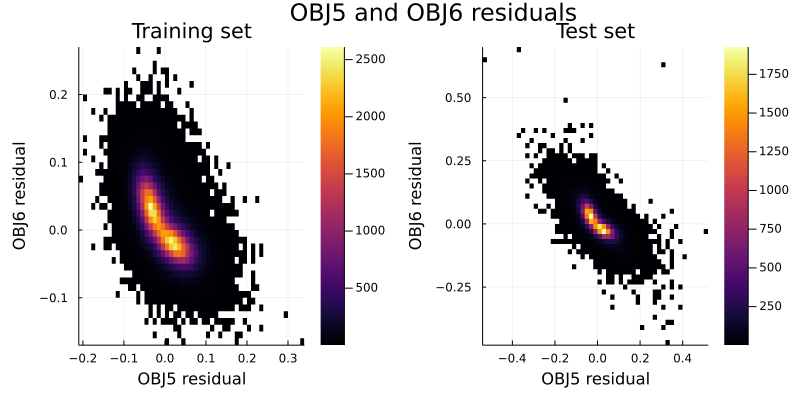

In [26]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    residuals_train[:, 5], residuals_train[:, 6];
    xlabel="OBJ5 residual", ylabel="OBJ6 residual", label="train", legend=true,
    title="Training set", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    residuals_test[:, 5], residuals_test[:, 6];
    xlabel="OBJ5 residual", ylabel="OBJ6 residual", label="test", legend=true,
    title="Test set", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(800, 400), plot_title="OBJ5 and OBJ6 residuals",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

In [27]:
using Statistics;
println("Correlation between resids for 5 and 6 for train:")
println(Statistics.cor(residuals_train[:, 5], residuals_train[:, 6]))
println("Correlation between resids for 5 and 6 for test:")
println(Statistics.cor(residuals_test[:, 5], residuals_test[:, 6]))

Correlation between resids for 5 and 6 for train:
-0.6691527071253099
Correlation between resids for 5 and 6 for test:
-0.7331823453522273


In [28]:
using GLM;

fm = @formula(x6 ~ x5)
linearRegressor = lm(fm, DataFrame(residuals_train))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

x6 ~ 1 + x5

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error        t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)   0.00642481  7.41438e-5    86.65    <1e-99   0.00627949   0.00657013
x5           -0.650329    0.00173509  -374.81    <1e-99  -0.65373     -0.646928
─────────────────────────────────────────────────────────────────────────────────

In [29]:
r2(linearRegressor)

0.4477653454531292

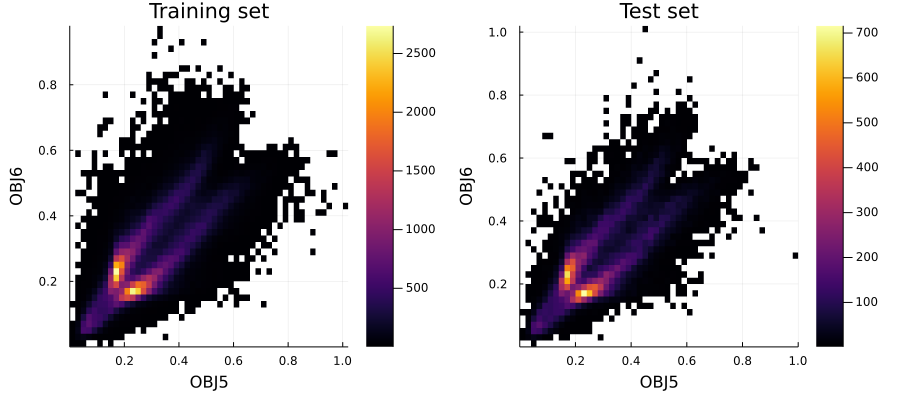

In [30]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    y_train[:, 5], y_train[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="train", legend=true,
    title="Training set", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    y_test[:, 5], y_test[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="test", legend=true,
    title="Test set", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

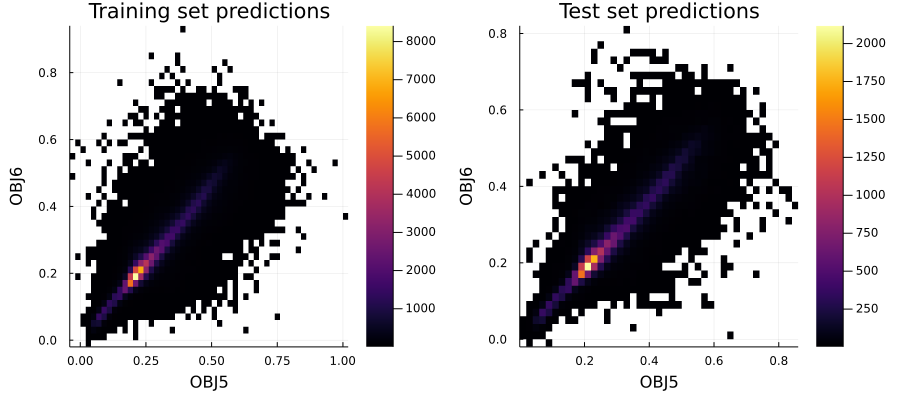

In [31]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    y_train_preds[:, 5], y_train_preds[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="train", legend=true,
    title="Training set predictions", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    y_test_preds[:, 5], y_test_preds[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="test", legend=true,
    title="Test set predictions", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)